## Data Loading

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'rice_leaf_disease_images',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 7926 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Healthy', 'Tungro']

In [5]:
len(dataset) #186*32=5931

248

In [6]:
# One random batch of images
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[3 3 4 4 4 4 0 2 0 3 0 1 2 2 2 0 2 4 1 4 1 1 1 3 1 2 0 1 1 3 2 2]


(32, 224, 224, 3)
[2 3 2 4 1 0 0 4 2 4 0 1 4 0 1 2 0 0 3 3 0 0 3 1 3 0 0 2 0 1 2 4]


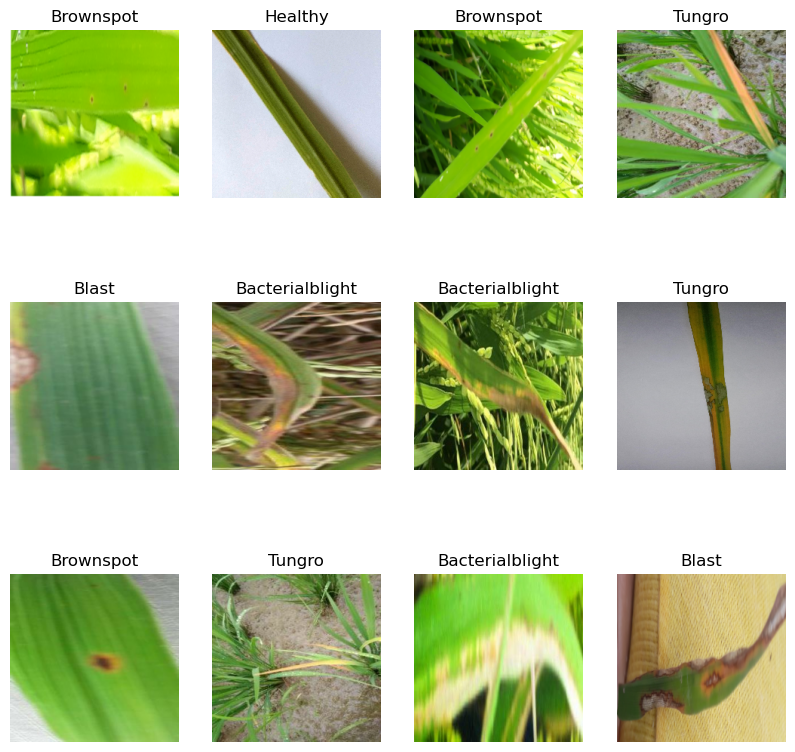

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12): #showing 12 images out of 32
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
# (32=batch_size, 256, 256=image_size, 0 to 3=typesofdiseases)
# 0 - Bacterial Blight
# 1 - Blast
# 2 - Brownspot
# 3 - Tungro

In [9]:
# Spitting dataset for training, validation and testing
# 80% for training 10% for validation and 10% for testing
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [11]:
# Catching and prefeching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Preprocessing

In [12]:
# Layer for resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## VGG16

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16

In [15]:
vgg16 = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),weights='imagenet',include_top=False)

In [16]:
# Don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [17]:
x = tf.keras.layers.Flatten()(vgg16.output)

In [18]:
prediction = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)

In [19]:
vgg16_model = tf.keras.Model(inputs=vgg16.input, outputs=prediction)

In [20]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
vgg16_model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy'])

In [22]:
logdir='logs'

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
history = vgg16_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[tensorboard_callback]
)

Epoch 1/30
198/198 [==============================] - 1314s 6s/step - loss: 2.1899 - accuracy: 0.8889 - val_loss: 0.5689 - val_accuracy: 0.9674
Epoch 2/30
198/198 [==============================] - 1559s 8s/step - loss: 0.4506 - accuracy: 0.9758 - val_loss: 0.3250 - val_accuracy: 0.9766
Epoch 3/30
198/198 [==============================] - 1846s 9s/step - loss: 0.2864 - accuracy: 0.9815 - val_loss: 0.4915 - val_accuracy: 0.9714
Epoch 4/30
198/198 [==============================] - 1860s 9s/step - loss: 0.1354 - accuracy: 0.9918 - val_loss: 0.2234 - val_accuracy: 0.9844
Epoch 5/30
198/198 [==============================] - 1514s 8s/step - loss: 0.1681 - accuracy: 0.9880 - val_loss: 0.4404 - val_accuracy: 0.9805
Epoch 6/30
198/198 [==============================] - 1363s 7s/step - loss: 0.1297 - accuracy: 0.9927 - val_loss: 0.2695 - val_accuracy: 0.9909
Epoch 7/30
198/198 [==============================] - 1439s 7s/step - loss: 0.0665 - accuracy: 0.9954 - val_loss: 0.1491 - val_accuracy:

In [ ]:
scores = vgg16_model.evaluate(test_ds)
scores

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    prediction_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    
    return prediction_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'predicted: {predicted_class},\n confidence: {confidence}, \n Actual: {actual_class}')
        plt.axis("off")

In [ ]:
# Saving the model
model_version = max([int(i) for i in os.listdir("new_models") + [0]])+1
model.save(f'new_models\{model_version}')

In [16]:
new_model = tf.keras.models.load_model('new_models/3')

# Check its architecture
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = new_model_3.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = tf.concat([y for x, y in test_ds], axis=0)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

In [ ]:
import numpy as np
import cv2

In [ ]:
img_path = cv2.imread(os.path.join('Testing Images','bs.jfif'))
img_path = cv2.cvtColor(img_path,cv2.COLOR_BGR2RGB)
plt.imshow(img_path)

In [ ]:
img = cv2.resize(img_path,(224,224))
img = np.reshape(img,[1,224,224,3])

In [ ]:
pred = new_model_3.predict(img)

In [ ]:
pred

In [ ]:
prediction_class = class_names[np.argmax(pred)]
prediction_class